In [21]:
#Importing Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from feature_engine.encoding import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score
from sklearn import tree
from kmodes.kprototypes import KPrototypes
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import chi2

# Data Preparation and some Basic EDA

In [2]:
#Read CSV file
df = pd.read_csv("dataset/train.csv")

In [3]:
#Looking for missing data
df.isnull().sum()

CustomerID           0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure               0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        9
Churn                0
dtype: int64

In [4]:
df[df["Total Charges"].isnull()]

,CustomerID,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
488,4472-LVYGI,0,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,1,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,0,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,1,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,0,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,1,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,1,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,0,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,1,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No


In [5]:
#Replacing NaN with 0 instead of dropping because customers might just started their first month and have not yet required to pay.
df["Total Charges"].replace(np.nan, 0, inplace = True)

In [6]:
#Mapping values for easier Tableau visualizations 
#And I like to look at Categorical Varialbes in their String form :D
df["Gender"] = df["Gender"].map({1: "Male", 0: "Female"})
df["Senior Citizen"] = df["Senior Citizen"].map({1: "Yes", 0: "No"})

In [7]:
origin = df.copy() #Extra Copy

In [8]:
origin.to_csv("dataset/origin.csv")

In [9]:
df.head()

,CustomerID,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
df.shape

(6499, 21)

In [12]:
df.duplicated().sum()

0

In [13]:
df.drop(columns = "CustomerID", inplace = True)

In [14]:
#Counting unique values in each categorical features
for _ in df.columns:
    if df[_].dtype == "O":
        print(f"{_}: ",Counter(df[_]))  

Gender:  Counter({'Male': 3290, 'Female': 3209})
Senior Citizen:  Counter({'No': 5443, 'Yes': 1056})
Partner:  Counter({'No': 3359, 'Yes': 3140})
Dependents:  Counter({'No': 4561, 'Yes': 1938})
Phone Service:  Counter({'Yes': 5884, 'No': 615})
Multiple Lines:  Counter({'No': 3138, 'Yes': 2746, 'No phone service': 615})
Internet Service:  Counter({'Fiber optic': 2860, 'DSL': 2217, 'No': 1422})
Online Security:  Counter({'No': 3208, 'Yes': 1869, 'No internet service': 1422})
Online Backup:  Counter({'No': 2855, 'Yes': 2222, 'No internet service': 1422})
Device Protection:  Counter({'No': 2843, 'Yes': 2234, 'No internet service': 1422})
Tech Support:  Counter({'No': 3209, 'Yes': 1868, 'No internet service': 1422})
Streaming TV:  Counter({'No': 2589, 'Yes': 2488, 'No internet service': 1422})
Streaming Movies:  Counter({'No': 2555, 'Yes': 2522, 'No internet service': 1422})
Contract:  Counter({'Month-to-month': 3576, 'Two year': 1565, 'One year': 1358})
Paperless Billing:  Counter({'Yes': 

In [15]:
df.describe()

,Tenure,Monthly Charges,Total Charges
count,6499.000000,6499.000000,6499.000000
mean,32.369134,64.733344,2279.773704
std,24.584693,30.136193,2270.050638
min,0.000000,18.250000,0.000000
25%,9.000000,35.400000,393.775000
50%,29.000000,70.350000,1393.600000
75%,55.000000,89.850000,3778.100000
max,72.000000,118.750000,8684.800000


# Feature Engineering and Selection

In [16]:
#Looking for strong correlations in Independent Variables
df.corr()

,Tenure,Monthly Charges,Total Charges
Tenure,1.000000,0.248949,0.825818
Monthly Charges,0.248949,1.000000,0.651940
Total Charges,0.825818,0.651940,1.000000


In [17]:
#Looking for dependency
pd.concat([pd.Series(df["Tenure"] * df["Monthly Charges"]).rename("Approximated Total Charges"),
                     df["Total Charges"]], axis = 1)

,Approximated Total Charges,Total Charges
0,29.85,29.85
1,1936.30,1889.50
2,107.70,108.15
3,1903.50,1840.75
4,141.40,151.65
...,...,...
6494,774.80,786.50
6495,69.65,69.65
6496,4074.00,4086.30
6497,5358.60,5364.80


In [18]:
#Total Charges can be approximated by multiplying Tenure with Monthly Charges.
#Hence, dropping Total Charges is ideal because it is high-correlated with Tenure
df.drop(columns = "Total Charges", inplace = True)

In [19]:
#Setting y as the outcome variable.
Churn = df["Churn"].map({"Yes": 1, "No": 0})
df.drop(columns = "Churn", inplace = True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             6499 non-null   object 
 1   Senior Citizen     6499 non-null   object 
 2   Partner            6499 non-null   object 
 3   Dependents         6499 non-null   object 
 4   Tenure             6499 non-null   int64  
 5   Phone Service      6499 non-null   object 
 6   Multiple Lines     6499 non-null   object 
 7   Internet Service   6499 non-null   object 
 8   Online Security    6499 non-null   object 
 9   Online Backup      6499 non-null   object 
 10  Device Protection  6499 non-null   object 
 11  Tech Support       6499 non-null   object 
 12  Streaming TV       6499 non-null   object 
 13  Streaming Movies   6499 non-null   object 
 14  Contract           6499 non-null   object 
 15  Paperless Billing  6499 non-null   object 
 16  Payment Method     6499 

In [22]:
#Encoding Features
dummy_list = [_ for _ in df.columns if df[_].dtype == "O"]
encoder = OrdinalEncoder(encoding_method='ordered', variables = dummy_list)
df = encoder.fit_transform(df, Churn)

In [23]:
encoder.encoder_dict_

{'Gender': {'Male': 0, 'Female': 1},
 'Senior Citizen': {'No': 0, 'Yes': 1},
 'Partner': {'Yes': 0, 'No': 1},
 'Dependents': {'Yes': 0, 'No': 1},
 'Phone Service': {'No': 0, 'Yes': 1},
 'Multiple Lines': {'No phone service': 0, 'No': 1, 'Yes': 2},
 'Internet Service': {'No': 0, 'DSL': 1, 'Fiber optic': 2},
 'Online Security': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Online Backup': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Device Protection': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Tech Support': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Streaming TV': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Streaming Movies': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Contract': {'Two year': 0, 'One year': 1, 'Month-to-month': 2},
 'Paperless Billing': {'No': 0, 'Yes': 1},
 'Payment Method': {'Credit card (automatic)': 0,
  'Bank transfer (automatic)': 1,
  'Mailed check': 2,
  'Electronic check': 3}}

In [24]:
#The majority features are categorical. Furthermore, we are predicting a binary outcome. 
#Thus we could use Hypothesis test for independence (Chi-Squared) for feature selections.
chi_scores = chi2(df[dummy_list],Churn)
chi_scores

(array([3.70028941e-01, 1.19148773e+02, 6.92743204e+01, 5.14064383e+01,
        6.01327539e-02, 2.05244530e+00, 3.21944810e+02, 3.55787543e+02,
        2.68209869e+02, 2.51487846e+02, 3.48947481e+02, 1.29445028e+02,
        1.34184051e+02, 5.41735993e+02, 1.02771568e+02, 3.64796159e+02]),
 array([5.42988493e-001, 9.71619979e-028, 8.56778936e-017, 7.50918684e-013,
        8.06286240e-001, 1.51961948e-001, 5.46114079e-072, 2.32728320e-079,
        2.78653953e-060, 1.23049406e-056, 7.18358855e-078, 5.41968517e-030,
        4.97983399e-031, 7.90263814e-120, 3.76108699e-024, 2.54245362e-081]))

In [25]:
p_values = pd.Series(chi_scores[1], index = df[dummy_list].columns)
p_values.sort_values(ascending = False, inplace = True)

<AxesSubplot:>

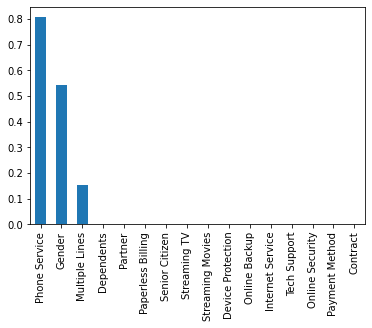

In [26]:
p_values.plot.bar()

In [27]:
#Phone Service and Gender features exceeds the 5% significance level threshold
#This indicates that Churn Rate is independent of Gender and the type of Phone Service. 
#Thus, they will be removed from the model training.
df.drop(columns = ["Phone Service","Gender"], inplace = True)

In [28]:
#Earlier, we found that the Outcome Variable is imbalanced. 
#Hence, we oversample randomly the least frequent outcome value which is "Yes" to create a balanced dataset.    
sm = RandomOverSampler(random_state = 1)
X, y = sm.fit_resample(df, Churn)
Counter(y)

Counter({0: 4784, 1: 4784})

# Modelling

In [31]:
#Splitting the dataset.
X_train, X_test, y_train, y_test = train_test_split(X.values,
                                                    y.values,
                                                    test_size = 0.25,
                                                    random_state = 1)

In [32]:
#Testing the model
model = RandomForestClassifier(random_state = 2)
model.fit(X_train,y_train)

RandomForestClassifier(random_state=2)

In [34]:
model.score(X_train,y_train), model.score(X_test,y_test)

(0.9974916387959866, 0.8783444816053512)

In [35]:
#Looking for important features
pd.DataFrame({"Feature": X.columns,
              "Importance": model.feature_importances_,}).sort_values(by = "Importance", ascending = False)

,Feature,Importance
3,Tenure,0.224310
15,Monthly Charges,0.221370
12,Contract,0.127877
14,Payment Method,0.066797
6,Online Security,0.057472
9,Tech Support,0.048566
5,Internet Service,0.035246
7,Online Backup,0.029257
4,Multiple Lines,0.028046
13,Paperless Billing,0.026453


# Hyperparameter Tuning

In [36]:
#Tree-based models are prone to overfitting. Hence we will search for optimal parameters with GridsearchCV
parameters = {
    "max_features": [11, 15, 19, 30],
    "min_samples_leaf": [2, 9, 30],
    "max_depth": [11, 15, 19],
    "min_samples_split": [5, 10, 40, 80]
    }

In [37]:
clf = GridSearchCV(RandomForestClassifier(random_state = 1), parameters, cv = 10, n_jobs = -1)

In [38]:
clf.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [11, 15, 19],
                         'max_features': [11, 15, 19, 30],
                         'min_samples_leaf': [2, 9, 30],
                         'min_samples_split': [5, 10, 40, 80]})

In [39]:
clf.best_estimator_

RandomForestClassifier(max_depth=19, max_features=11, min_samples_leaf=2,
                       min_samples_split=5, random_state=1)

In [40]:
#Use the Best parameters for the final model
final_model = RandomForestClassifier(max_depth = 19, 
                                     max_features = 11, 
                                     min_samples_leaf = 2, 
                                     min_samples_split = 5,
                                     random_state = 1)

In [41]:
final_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=19, max_features=11, min_samples_leaf=2,
                       min_samples_split=5, random_state=1)

In [42]:
#Score for training 
final_model.score(X_train,y_train)

0.9725473801560758

In [43]:
#Confusion Matrix for Training
y_train_pred = final_model.predict(X_train)
confusion_matrix(y_train, y_train_pred)

array([[3429,  152],
       [  45, 3550]], dtype=int64)

In [44]:
#Score for testing 
final_model.score(X_test,y_test)

0.8486622073578596

In [45]:
#Confusion Matrix for Testing
y_test_pred = final_model.predict(X_test)
confusion_matrix(y_test,y_test_pred)

array([[ 944,  259],
       [ 103, 1086]], dtype=int64)

In [46]:
#Score for un-oversampled dataset
final_model.score(df,Churn)

0.9238344360670873

In [47]:
#Confusion Matrix for un-oversampled dataset
Churn_predicted = final_model.predict(df)
confusion_matrix(Churn,Churn_predicted)

array([[4373,  411],
       [  84, 1631]], dtype=int64)

In [48]:
#Cross validate again to see if the model performs well on different blocks of data
cv_scores = cross_val_score(final_model, X_train, y_train, cv = 10)

In [49]:
#Results don't seem to fluctuate greatly, which indicates the model performs reasonably well
print(cv_scores)
print(f"cv_scores mean: {np.mean(cv_scores)}")

[0.8718663  0.85376045 0.85654596 0.83983287 0.85654596 0.85654596
 0.88563459 0.86610879 0.84797768 0.86471409]
cv_scores mean: 0.8599532639479728


In [50]:
#Looking for Feature Importance again
feature_importance = pd.DataFrame({"Feature": X.columns,
                                   "Importance": final_model.feature_importances_}).sort_values(by=["Importance"], ascending = False)

In [51]:
#Top 3 features on total has increased about 7% in importance comparing to the first model. 
feature_importance

,Feature,Importance
12,Contract,0.228745
15,Monthly Charges,0.222981
3,Tenure,0.194074
6,Online Security,0.055899
14,Payment Method,0.050741
9,Tech Support,0.048240
5,Internet Service,0.038168
13,Paperless Billing,0.022510
4,Multiple Lines,0.021052
7,Online Backup,0.020762


In [52]:
#Saving the data for Tableau Visualization
feature_importance.to_csv("dataset/feature_importance.csv", index = False)

# Predicting Real World Dataset

In [53]:
df_real = pd.read_csv("dataset/test.csv")

In [54]:
#Dropping the exact features that have been dropped in the Feature Engineering and Selection Step.
df_real.drop(columns = ["CustomerID", "Total Charges", "Gender", "Phone Service"], inplace = True)

In [55]:
##Mapping values for easier visualizations
df_real["Senior Citizen"] = df_real["Senior Citizen"].map({1: "Yes", 0: "No"})

In [56]:
df.head()

,Senior Citizen,Partner,Dependents,Tenure,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges
0,0,0,1,1,0,1,2,1,2,2,2,2,2,1,3,29.85
1,0,1,1,34,1,1,1,2,1,2,2,2,1,0,2,56.95
2,0,1,1,2,1,1,1,1,2,2,2,2,2,1,2,53.85
3,0,1,1,45,0,1,1,2,1,1,2,2,1,0,1,42.30
4,0,1,1,2,1,2,2,2,2,2,2,2,2,1,3,70.70


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     6499 non-null   int64  
 1   Partner            6499 non-null   int64  
 2   Dependents         6499 non-null   int64  
 3   Tenure             6499 non-null   int64  
 4   Multiple Lines     6499 non-null   int64  
 5   Internet Service   6499 non-null   int64  
 6   Online Security    6499 non-null   int64  
 7   Online Backup      6499 non-null   int64  
 8   Device Protection  6499 non-null   int64  
 9   Tech Support       6499 non-null   int64  
 10  Streaming TV       6499 non-null   int64  
 11  Streaming Movies   6499 non-null   int64  
 12  Contract           6499 non-null   int64  
 13  Paperless Billing  6499 non-null   int64  
 14  Payment Method     6499 non-null   int64  
 15  Monthly Charges    6499 non-null   float64
dtypes: float64(1), int64(15)

In [58]:
encoder.encoder_dict_

{'Gender': {'Male': 0, 'Female': 1},
 'Senior Citizen': {'No': 0, 'Yes': 1},
 'Partner': {'Yes': 0, 'No': 1},
 'Dependents': {'Yes': 0, 'No': 1},
 'Phone Service': {'No': 0, 'Yes': 1},
 'Multiple Lines': {'No phone service': 0, 'No': 1, 'Yes': 2},
 'Internet Service': {'No': 0, 'DSL': 1, 'Fiber optic': 2},
 'Online Security': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Online Backup': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Device Protection': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Tech Support': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Streaming TV': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Streaming Movies': {'No internet service': 0, 'Yes': 1, 'No': 2},
 'Contract': {'Two year': 0, 'One year': 1, 'Month-to-month': 2},
 'Paperless Billing': {'No': 0, 'Yes': 1},
 'Payment Method': {'Credit card (automatic)': 0,
  'Bank transfer (automatic)': 1,
  'Mailed check': 2,
  'Electronic check': 3}}

In [59]:
#Dummy Encoding using function. This step would point mappings correctly from earlier encoder to the new dataset.
def create_dummy(data_frame):
    for _ in data_frame.columns:
        if _ in encoder.encoder_dict_.keys():
            data_frame[_] = data_frame[_].map(encoder.encoder_dict_[_])
        else:
            print("Excluded Features:", _)

In [60]:
create_dummy(df_real)

Excluded Features: Tenure
Excluded Features: Monthly Charges


In [61]:
df_real.head()

,Senior Citizen,Partner,Dependents,Tenure,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges
0,0,1,1,1,1,0,0,0,0,0,0,0,2,0,2,20.30
1,0,1,1,21,0,1,1,2,2,1,2,2,0,0,2,35.10
2,0,0,1,67,2,2,2,1,1,2,1,1,1,1,1,105.70
3,0,0,0,44,1,1,1,2,2,1,2,2,2,0,1,56.25
4,0,0,0,70,0,1,2,1,1,1,1,1,1,0,3,60.35


In [62]:
#Predicting real world dataset
y_real_pred = final_model.predict(df_real)

In [63]:
#Counting Outcome Values
Counter(y_real_pred)

Counter({0: 369, 1: 175})

In [64]:
df_real["Churn"] = y_real_pred

In [65]:
#Since the real world dataset doesn't have absolute correct churn value, We can only do comparisions
df_real[df_real["Churn"] == 1].head(10)

,Senior Citizen,Partner,Dependents,Tenure,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn
5,0,1,1,3,1,2,2,2,2,2,1,2,2,0,3,79.25,1
7,0,1,1,13,2,2,2,2,2,2,2,1,2,1,3,84.60,1
10,1,0,1,1,0,1,2,2,2,2,2,2,2,0,3,25.05,1
17,0,1,0,1,1,1,2,2,1,2,2,2,2,0,3,48.95,1
19,0,1,1,1,1,1,2,2,2,2,2,2,2,0,3,45.30,1
21,0,1,1,2,1,2,2,2,1,2,2,1,2,1,3,85.85,1
23,0,0,1,43,0,1,1,2,2,1,2,2,2,0,1,34.00,1
25,0,1,0,10,2,2,2,2,2,2,1,1,2,0,3,95.20,1
34,1,0,1,28,2,2,2,1,2,1,1,1,2,1,3,105.80,1
38,0,0,1,70,2,2,1,1,1,1,1,1,1,0,0,115.65,1


In [66]:
df_concat = pd.concat([X,y], axis = 1)

In [67]:
df_concat[df_concat["Churn"] == 1].head(10)

,Senior Citizen,Partner,Dependents,Tenure,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn
2,0,1,1,2,1,1,1,1,2,2,2,2,2,1,2,53.85,1
4,0,1,1,2,1,2,2,2,2,2,2,2,2,1,3,70.70,1
5,0,1,1,8,2,2,2,2,1,2,1,1,2,1,3,99.65,1
8,0,0,1,28,2,2,2,2,1,1,1,1,2,1,3,104.80,1
13,0,1,1,49,2,2,2,1,1,2,1,1,2,1,1,103.70,1
18,0,0,0,10,1,1,2,2,1,1,2,2,2,0,0,55.20,1
20,1,1,1,1,0,1,2,2,1,2,2,1,2,1,3,39.65,1
22,0,1,1,1,1,0,0,0,0,0,0,0,2,0,2,20.15,1
26,0,0,0,47,2,2,2,1,2,2,1,1,2,1,3,99.35,1
27,0,0,0,1,0,1,2,1,2,2,2,2,2,0,3,30.20,1


# Clustering on customers who churned for re-marketing purposes

In [68]:
#Viewing dataset from the copied dataset from earlier.
origin.head()

,CustomerID,Gender,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [69]:
#Setting Churn equating "Yes" to do Clustering
df2 = origin[origin["Churn"] == "Yes"]

In [70]:
#Dropping the exact features that have been dropped in the Feature Engineering and Selection Step.
df2.drop(columns = ["CustomerID","Gender","Phone Service","Total Charges", "Churn"], inplace = True) 

In [71]:
df2.shape

(1715, 16)

In [72]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1715 entries, 2 to 6498
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     1715 non-null   object 
 1   Partner            1715 non-null   object 
 2   Dependents         1715 non-null   object 
 3   Tenure             1715 non-null   int64  
 4   Multiple Lines     1715 non-null   object 
 5   Internet Service   1715 non-null   object 
 6   Online Security    1715 non-null   object 
 7   Online Backup      1715 non-null   object 
 8   Device Protection  1715 non-null   object 
 9   Tech Support       1715 non-null   object 
 10  Streaming TV       1715 non-null   object 
 11  Streaming Movies   1715 non-null   object 
 12  Contract           1715 non-null   object 
 13  Paperless Billing  1715 non-null   object 
 14  Payment Method     1715 non-null   object 
 15  Monthly Charges    1715 non-null   float64
dtypes: float64(1), int64(1),

In [73]:
#Creating index of categorical features to pass in model training  
categorical_list = [k for k,v in enumerate(df2.columns) if df2[v].dtype == "O"]

In [74]:
categorical_list

[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [75]:
#Dummy encoding using function created earlier to fit into the clustering model
#Not necessary for fitting Kprototypes but Sklearn's Silhoulette scrore requires the dataframe to be label-encoded.
df2_encoded = df2.copy() #Extra Copy
create_dummy(df2_encoded)

Excluded Features: Tenure
Excluded Features: Monthly Charges


In [76]:
#Looking for the optimal number of k. 
score = []
for _ in range(2,10):
    kproto = KPrototypes(n_clusters = _, max_iter = 30)
    clusters = kproto.fit_predict(df2_encoded, categorical = categorical_list)
    score.append(silhouette_score(df2_encoded,clusters))

Text(0.5, 1.0, 'Silhoulette Score by Number of Clusters')

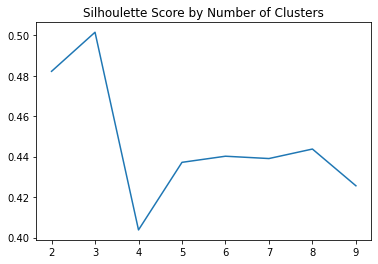

In [77]:
#Plotting Silhoulette Score
plt.plot(range(2,10),score)
plt.title("Silhoulette Score by Number of Clusters")

In [78]:
#Building Final Clustering Model, Choosing k = 3 since it returns the highest Silhoulette Score. 
kproto_final = KPrototypes(n_clusters = 3, max_iter = 30)

In [79]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1715 entries, 2 to 6498
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Senior Citizen     1715 non-null   object 
 1   Partner            1715 non-null   object 
 2   Dependents         1715 non-null   object 
 3   Tenure             1715 non-null   int64  
 4   Multiple Lines     1715 non-null   object 
 5   Internet Service   1715 non-null   object 
 6   Online Security    1715 non-null   object 
 7   Online Backup      1715 non-null   object 
 8   Device Protection  1715 non-null   object 
 9   Tech Support       1715 non-null   object 
 10  Streaming TV       1715 non-null   object 
 11  Streaming Movies   1715 non-null   object 
 12  Contract           1715 non-null   object 
 13  Paperless Billing  1715 non-null   object 
 14  Payment Method     1715 non-null   object 
 15  Monthly Charges    1715 non-null   float64
dtypes: float64(1), int64(1),

In [80]:
#Fit and assign cluster.
model_clusters = kproto_final.fit_predict(df2, categorical = categorical_list)

In [81]:
model_clusters

array([0, 1, 1, ..., 1, 2, 1], dtype=uint16)

In [82]:
#Counting frequency of clusters
Counter(model_clusters)

Counter({0: 445, 1: 868, 2: 402})

In [83]:
#Grid Search to find the best parameters to interpret the clusters
Decision_params = {"min_samples_leaf": [25, 30, 45, 60],
                   "max_depth": [3, 4, 5, 6, 8, 10, 12],
                   "min_samples_split": [30, 40, 50, 60, 70, 80]}

In [84]:
search = GridSearchCV(DecisionTreeClassifier(), Decision_params, n_jobs = -1)

In [85]:
search.fit(df2_encoded, model_clusters)

GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 8, 10, 12],
                         'min_samples_leaf': [25, 30, 45, 60],
                         'min_samples_split': [30, 40, 50, 60, 70, 80]})

In [86]:
#Search for the best parameters
search.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=25, min_samples_split=30)

In [87]:
search.score(df2_encoded,model_clusters)

0.9714285714285714

In [98]:
#Build model with the exact best parameters for visualizing clusters
Decision = DecisionTreeClassifier(min_samples_split = 30,
                                  max_depth = 3, 
                                  min_samples_leaf = 25)
Decision = Decision.fit(df2_encoded, model_clusters)
Decision.score(df2_encoded,model_clusters)

0.9714285714285714

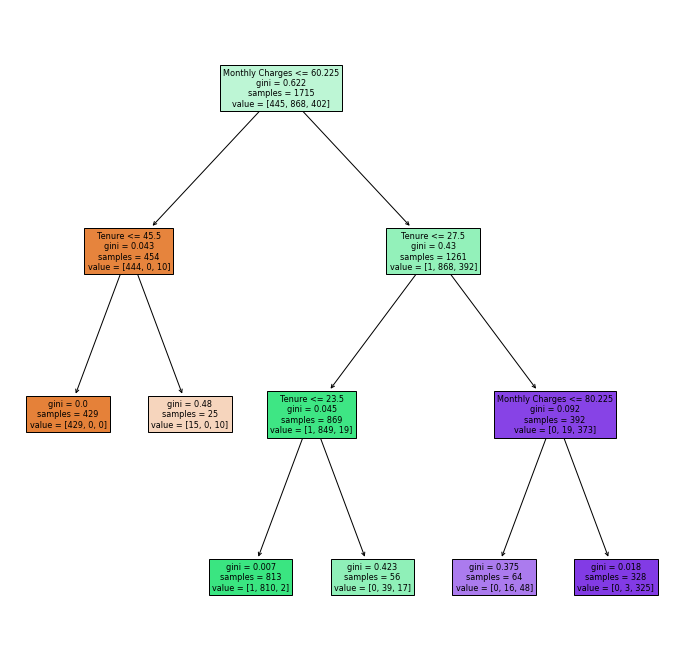

In [99]:
#Visualizing clusters
fig = plt.figure(figsize=(12,12))
_ = tree.plot_tree(Decision, 
                   feature_names = df2_encoded.columns,
                   filled=True)

In [100]:
#GREEN CLUSTER: Monthly Charges < 60.225 and Tenure < 27.5 (Account for 24% of the Total Population)
#GREEN CLUSTER: Monthly Charges < 60.225 and Tenure > 27.5 (Account for 1% of the Total Population)

#ORANGE CLUSTER: Monthly Charges > 60.225 and Tenure < 23.5 (Account for ~49% of the Total Population)
#ORANGE CLUSTER: Monthly Charges > 60.225 and Tenure > 23.5 (Account for ~2% of the Total Population)

#VIOLET: Monthly Charges > 80.225 and Tenure > 27.5 (Account for ~19% of the Total Population)
#VIOLET: Monthly Charges between 60.225 and 80.225 and Tenure > 27.5 (Account for 2% of the Total Population)

In [102]:
df2.head()

,Senior Citizen,Partner,Dependents,Tenure,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges
2,No,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85
4,No,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70
5,No,No,No,8,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65
8,No,Yes,No,28,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80
13,No,No,No,49,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70


In [103]:
df2["Cluster"] = model_clusters

In [104]:
df2["Cluster"]

2       0
4       1
5       1
8       2
13      2
       ..
6489    0
6491    1
6495    1
6496    2
6498    1
Name: Cluster, Length: 1715, dtype: uint16

In [105]:
Counter(df2["Cluster"])

Counter({0: 445, 1: 868, 2: 402})

In [106]:
df2["Cluster"] = df2["Cluster"].map({0: "Orange", 1: "Green", 2: "Purple"})

In [107]:
df2.to_csv("dataset/dataset with cluster.csv")